# Lab CMBLenses

## Model

In [56]:
] activate "/home/jaimerz/julia_repos/CMBLensingInferenceTestProblem"

  Activating project at `~/julia_repos/CMBLensingInferenceTestProblem`


In [57]:
using CMBLensing, CMBLensingInferenceTestProblem
using CUDA, LaTeXStrings, MCMCDiagnosticTools, Plots, ProgressMeter, Random, Zygote
using LinearAlgebra, Statistics
ENV["LINES"] = 10;

In [58]:
using Revise
using MCHMC

In [121]:
prob = load_cmb_lensing_problem(storage = Array,
                                T = Float32,
                                Nside = 4);

MAP_joint: 100%|████████████████████████████████████████| Time: 0:00:11
  step:        20
  logpdf:      377.00
  α:           0.008522608
  CG:          2 iterations
  Linesearch:  9 bisections


In [163]:
target = CMBLensingTarget(prob);

In [164]:
sqrt_MM = sqrt(real(prob.Λmass))
inv_sqrt_MM = pinv(sqrt_MM)

38×38 Diagonal{Float64, Field-(f°,ϕ°,θ)-Tuple{LambertEBFourier{Array{Float32, 3}}, LambertFourier{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}:
 0.0   ⋅         ⋅         ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   0.486508   ⋅         ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅        0.760307   ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
 ⋮                                  ⋮    ⋱                      ⋮         
  ⋅    ⋅         ⋅         ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅         ⋅         ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0

In [161]:
LenseBasis(sqrt_MM * prob.Ωstart)

50-element Field-(f°,ϕ°,θ)-Tuple{LambertQUMap{Array{Float32, 3}}, LambertMap{Array{Float32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}:
  0.49172186851501465
  3.3348827362060547
 -3.8632519245147705
  ⋮
 -1.6094379124341003
  0.0

In [125]:
function ff(x)
    return x
end
function prior(x)
    return prob.Ωstart
end

function nlogp(x)
        #x = inv_transform(xt)
        return -1.0 .* prob(x)
    end

function grad_nlogp(x)
    return CMBLensing.LenseBasis(Zygote.gradient(nlogp, x)[1])
end

target_no_t = CMBLensingTarget(prob)
target_no_t.transform = ff
target_no_t.inv_transform = ff
target_no_t.prior_draw = fff
target_no_t.nlogp = nlogp
target_no_t.grad_nlogp = grad_nlogp

grad_nlogp (generic function with 1 method)

[-0.30936679244041443, -0.8185905814170837, -0.5983972549438477, -0.8185905814170837, 0.9873343706130981, -0.4218532145023346, -0.8361046314239502, 0.7030996084213257, 0.8796437978744507, 0.10486790537834167, 0.5906134843826294, 0.10486790537834167, 0.9873343706130981, 0.7030996084213257, -0.8361046314239502, -0.4218532145023346, 0.2826554477214813, -0.8024191856384277, -0.3653070628643036, -0.8024191856384277, 0.6600601673126221, 0.8299111723899841, 0.18301627039909363, -1.110504150390625, 0.08471392095088959, 0.5205287933349609, -0.5632485747337341, 0.5205287933349609, 0.6600601673126221, -1.110504150390625, 0.18301627039909363, 0.8299111723899841, 3.447042826515251e16, -2.4582228138786816e16, 2.0652195623993344e16, -2.4582228138786816e16, -2.1687518965530624e16, 1.2603112304934912e16, -9.308119695884288e15, 1.2603112304934912e16, 2.0652195623993344e16, -1.220282886914048e16, 9.374122605805568e15, -1.220282886914048e16, -2.1687518965530624e16, 1.2603112304934912e16, -9.30811969588428

In [155]:
CMBLensing.LenseBasis(prob.Λmass)

38×38 Diagonal{ComplexF64, Field-(f°,ϕ°,θ)-Tuple{LambertEBFourier{Array{Float32, 3}}, LambertFourier{Array{ComplexF32, 2}}, ComponentArrays.ComponentVector{Float64, Vector{Float64}, Tuple{ComponentArrays.Axis{(r = 1, Aϕ = 2)}}}}}:
 0.0+0.0im          ⋅              ⋅      …      ⋅          ⋅          ⋅    
     ⋅      4.22494+0.0im          ⋅             ⋅          ⋅          ⋅    
     ⋅              ⋅      1.72991+0.0im         ⋅          ⋅          ⋅    
    ⋮                                     ⋱     ⋮                  
     ⋅              ⋅              ⋅             ⋅      1.0+0.0im      ⋅    
     ⋅              ⋅              ⋅             ⋅          ⋅      1.0+0.0im

## Sample

In [126]:
eps=0.0000001
L=sqrt(target.d)
spl=Sampler(;eps=eps, L=L)

Sampler(Settings(MersenneTwister(0), 1.0e-7, 7.0710678118654755, 0.0, 0.1931833275037836, 0.0005, 2000, 1000, 10, "LF"), MCHMC.Leapfrog)

In [127]:
init = MCHMC.Get_initial_conditions(spl, target)
x, g, u, r, t = init

([0.42004072666168213, 1.7844752073287964, -2.439671516418457, -3.621648073196411, 0.8699802160263062, 3.4578683376312256, -1.362741231918335, -3.1474339962005615, 1.9923657178878784, 10.040186882019043  …  -2.3630020582326814e-17, 3.313013191145788e-19, 4.8310282609910154e-17, 1.0969451379760676e-17, -3.9453762361700844e-17, -2.0808199801720566e-17, 2.654735590826456e-17, -8.144055524546975e-18, -1.6094379124341003, 0.0], [0.17260724306106567, -0.01843095012009144, -0.01767706125974655, 0.0033818338997662067, 0.134495347738266, -0.015604629181325436, -0.16652120649814606, 0.055239398032426834, 0.03427109867334366, -0.33826956152915955  …  0.02685372158885002, 0.23181548714637756, 0.06816983968019485, 0.14649169147014618, 0.1131039634346962, -0.3359872102737427, -0.22112472355365753, 0.15401597321033478, 0.05994229142272867, -0.1139912315094927], [-9.9634085870548e-8, 2.877720532978856e-7, -5.532990030587825e-7, -4.571329270675051e-7, 8.024439068776701e-8, 6.157576990517555e-7, -1.3532

In [128]:
uu, rr = MCHMC.Update_momentum(spl, target, eps * 0.5, g, u, r)

#full step in x
xx = x .- eps .* uu
gg = target.grad_nlogp(xx)
println(gg)

LoadError: DomainError with -6.91059205942105:
log1p will only return a complex result if called with a complex argument. Try log1p(Complex(x)).

In [131]:
init = MCHMC.Get_initial_conditions(spl, target_no_t)
x, g, u, r, t = init

([0.23362982273101807, 1.6145217418670654, -1.8872356414794922, -3.2767221927642822, 0.8644531965255737, 2.2458934783935547, -1.246073603630066, -2.639155864715576, 1.868626356124878, 3.251345157623291  …  -3.395840053599386e-9, 3.6597669339499816e-11, 4.677404241704153e-9, 1.211756028851596e-9, -5.810230518932258e-9, -2.3360031686792126e-9, 2.561251877253312e-9, -9.142808177209361e-10, -1.6094379124341003, 0.0], [-0.17509743571281433, -0.2546156644821167, -0.12893405556678772, -0.016462236642837524, -0.0793110728263855, 0.1729809045791626, 0.06115751340985298, 0.197920024394989, 0.021481221541762352, 0.2348160296678543  …  -0.13934938609600067, 0.20598673820495605, 0.06823858618736267, 0.08237851411104202, -0.1119808480143547, 0.13035975396633148, 0.09473720192909241, -0.022775618359446526, -0.1394116566676119, 0.11836720497329495], [-3.002088817538606e-7, 3.2172076203096367e-7, -5.61635943086003e-7, -5.00593102970015e-7, 1.5009730702786328e-7, 1.0105396768267383e-6, -7.81606033228854

In [132]:
uu, rr = MCHMC.Update_momentum(spl, target_no_t, eps * 0.5, g, u, r)

#full step in x
xx = x .- eps .* uu
gg = target_no_t.grad_nlogp(xx)
println(gg)

[-1.0743605522911055e6, 3.163609095641993e6, 2.222271800294089e6, -3.4443900169423334e6, 1.851674971898655e6, -1.4045471833820012e6, -2.766368079221209e6, 1.2273253092835764e6, -2.45436114039471e6, 1.5819733234633708e6, 1.307215880976499e6, -1.3024066042274183e6, 2.609630453654102e6, 210530.62755659, -1.6949213305980067e6, -32876.55571209139, -842233.3949850469, 1.2335134714533975e6, 1.1174714515323213e6, -1.54592449257026e6, 1.453886419586073e6, -886902.9906057053, -1.6818738460583019e6, 825701.2040700411, -1.145919963558008e6, 848513.8266021815, 870700.2364908839, -536125.3496143495, 1.0348230188037808e6, -132274.97801914113, -806854.3961515721, 193499.78302370594, 7.507326566503225e13, 1.3954718901321728e14, 2.3138090526443588e14, -1.5547973029903728e14, -3.446255453699985e13, -1.2259666817994931e14, 1.5544714856540148e13, -5.128172478451406e11, 1.0697393285645431e14, 9.302362583346688e13, -8.207684066487194e13, 2.6919470102040742e13, -1.7639918479369122e14, -3.086673364964731e14, 1

In [94]:
xx, gg, uu, rr = MCHMC.Leapfrog(spl, target, x, g, u, r)
println(gg)

[-7.431067394222076e6, 2.5075948711289823e7, 1.853318311717564e7, -2.7721164615957446e7, 1.6498115325588075e7, -1.3763776855217919e7, -2.3515220324859187e7, 7.025962959674831e6, -2.0074683194581583e7, 1.6348418833426636e7, 8.971595389173135e6, -1.3701448173427954e7, 2.309637005424827e7, 7.587933639338203e6, -1.6079514856925195e7, -850652.6147232477, -9.503934712591337e6, 1.5880077452571202e7, 1.351449774864374e7, -1.815338594007718e7, 1.658805510499602e7, -1.0032722717190558e7, -2.048525105277442e7, 9.679905296452567e6, -1.4560602562178358e7, 1.0106172279119803e7, 1.0550016161904799e7, -7.832833206096002e6, 1.31860347831213e7, -1.9311141223244788e6, -9.288824186157268e6, 2.28390967258018e6, -4.80184922585567e15, 1.0057781085409606e15, -1.0616407573257074e16, 7.827660585174753e15, 1.5715569983752212e15, 2.8510915284964315e15, -8.47367838253293e14, -7.559092845466508e14, -4.342848455329508e15, -1.2034670873109402e15, 1.601314402361804e15, 1.2542888401393035e15, 5.386855532941893e15, 7.04

In [95]:
samples = Sample(spl, target; num_steps=100)

101-element Vector{Vector{Float64}}:
 [0.23362982273101807, 1.6145217418670654, -1.8872356414794922, -3.2767221927642822, 0.8644531965255737, 2.2458934783935547, -1.246073603630066, -2.639155864715576, 1.868626356124878, 3.251345157623291  …  -3.395840053599386e-9, 3.6597669339499816e-11, 4.677404241704153e-9, 1.211756028851596e-9, -5.810230518932258e-9, -2.3360031686792126e-9, 2.561251877253312e-9, -9.142808177209361e-10, -1.6094379124341003, 0.0]
 [0.23362981750823134, 1.614521733092397, -1.8872356272556534, -3.2767221706684673, 0.8644531720845814, 2.2458934760044453, -1.2460735758054418, -2.6391558489995846, 1.8686263515620916, 3.251345180685893  …  2.4380552278769023e-8, 1.203290744744396e-8, 2.2817007469256005e-8, -1.0992845624813364e-8, 3.39366241447672e-10, -9.416496974024596e-9, -1.6457358534420342e-8, 6.768970788910391e-10, -1.609437904021631, -5.4310037314121e-9]
 [0.23362981750502457, 1.6145217330871195, -1.8872356272469883, -3.27672217065503, 0.8644531720697727, 2.245893476

## Plotting

In [96]:
Plots.default(fmt=:png, dpi=120, size=(500,300), legendfontsize=10)

In [97]:
rs = [sample[end] for sample in samples]
Aϕs = [sample[end-1] for sample in samples];

In [98]:
println(mean(exp.(rs)), " ", std(exp.(rs)))

0.999999994619362 5.407475371258813e-10


In [99]:
println(mean(exp.(Aϕs)), " ", std(exp.(Aϕs)))

0.2000000016668379 1.6751516490540135e-10


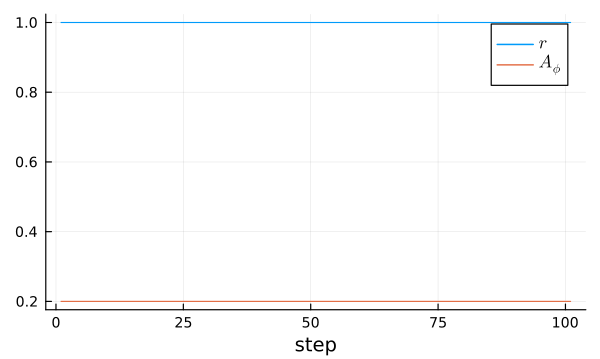

In [100]:
plot(exp.(rs), label=L"r", xlabel="step")
plot!(exp.(Aϕs), label=L"A_\phi")

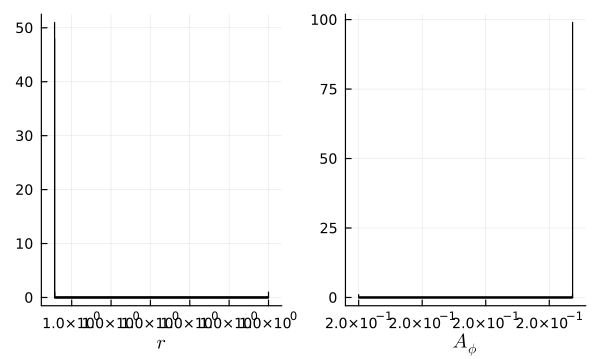

In [102]:
plot(histogram(exp.(rs), xlabel=L"r", label=nothing, lw=1),
    histogram(exp.(Aϕs), xlabel=L"A_\phi", label=nothing, lw=1))